# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Fri May 27 05:42:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 9.73 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease

In [1]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...


In [1]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

# RAPIDS is now installed on Colab.  You can copy your code into the cells below.  Enjoy!

In [3]:
import cudf
from cuml.tsa.arima import ARIMA
from cuml.tsa.auto_arima import AutoARIMA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


Visualization util

In [4]:
plt.rcParams["figure.figsize"] = (20,10)

In [88]:
def visualize(y, test=None, pred=None, pred_start=None, lower=None, upper=None):
    n_obs, batch_size = y.shape
    col = ["#1f77b4", "#ff7f0e"]

    # Create the subplots
    c = min(batch_size, 2)
    r = (batch_size + c - 1) // c
    fig, ax = plt.subplots(r, c, squeeze=False)
    ax = ax.flatten()
    
    # Range for the prediction
    if pred is not None:
        pred_start = n_obs if pred_start is None else pred_start
        pred_end = pred_start + pred.shape[0]
    else:
        pred_end = n_obs
    
    # Plot the data
    for i in range(batch_size):
        title = y.columns[i]
        if pred is not None:
            ax[i].plot(np.r_[pred_start:pred_end],
                       pred.to_numpy(),
                       linestyle="--", color=col[1], label = 'forecast')
        if test is not None:
            ax[i].plot(np.r_[pred_start:pred_end],
                       test[test.columns[i]].to_numpy(),
                       linestyle=":", color=col[0],label = 'test data')
        # Prediction intervals
        if lower is not None and upper is not None:
            ax[i].fill_between(np.r_[pred_start:pred_end],
                               lower[lower.columns[i]].to_numpy(),
                               upper[upper.columns[i]].to_numpy(),
                               alpha=0.2, color=col[1])
        ax[i].plot(np.r_[:n_obs], y[title].to_numpy(), color=col[0], label = 'train data')
        ax[i].title.set_text(title)
        ax[i].set_xlim((0, pred_end))
    for i in range(batch_size, r*c):
        fig.delaxes(ax[i])
    fig.tight_layout()
    fig.patch.set_facecolor('white')
    plt.show()

discard the date, and limit the batch size

In [245]:
def load_dataset(name, max_batch=804):
    import os
    pdf = pd.read_csv(os.path.join("%s.csv" % name))
    pdf = pdf[pdf.columns[0:max_batch+1]]
    pdf = pdf.set_index('Page')
    pdf = pdf.T
    #pdf = pdf.reset_index(drop=True)
    return pdf.astype(np.float64)

## Load data

In [246]:
df = cudf.from_pandas(load_dataset("data"))

In [236]:
df

,5566_zh.wikipedia.org_all-access_spider,Intel_80386_zh.wikipedia.org_all-access_spider,Kara_zh.wikipedia.org_all-access_spider,MAMAMOO_zh.wikipedia.org_all-access_spider,Netflix_zh.wikipedia.org_all-access_spider,SHINee_zh.wikipedia.org_all-access_spider,Healer_zh.wikipedia.org_all-access_spider,金秀賢_(男演員)_zh.wikipedia.org_all-access_spider,夏梦_zh.wikipedia.org_all-access_spider,洪小鈴_zh.wikipedia.org_all-access_spider,...,Bakú_es.wikipedia.org_all-access_spider,Día_de_la_Madre_es.wikipedia.org_all-access_spider,Frozen_(película_de_2013)_es.wikipedia.org_all-access_spider,Densidad_de_población_es.wikipedia.org_all-access_spider,Mariano_Díaz_Mejía_es.wikipedia.org_all-access_spider,Juan_Domingo_Perón_es.wikipedia.org_all-access_spider,Janucá_es.wikipedia.org_all-access_spider,Generación_Y_es.wikipedia.org_all-access_spider,Oxígeno_es.wikipedia.org_all-access_spider,Día_Internacional_del_Libro_es.wikipedia.org_all-access_spider
2015-07-01,12.0,7.0,56.0,8.0,7.0,37.0,8.0,12.0,9.0,17.0,...,12.0,13.0,7.0,30.0,6.0,91.0,9.0,8.0,74.0,8.0
2015-07-02,7.0,5.0,25.0,7.0,10.0,21.0,6.0,70.0,12.0,3.0,...,7.0,17.0,10.0,23.0,0.0,50.0,8.0,2.0,30.0,4.0
2015-07-03,4.0,9.0,7.0,17.0,21.0,24.0,15.0,30.0,11.0,21.0,...,17.0,12.0,16.0,28.0,1.0,32.0,8.0,5.0,41.0,5.0
2015-07-04,5.0,3.0,50.0,11.0,2.0,27.0,6.0,13.0,16.0,16.0,...,14.0,21.0,10.0,29.0,2.0,13.0,7.0,6.0,27.0,4.0
2015-07-05,20.0,5.0,90.0,8.0,9.0,35.0,7.0,9.0,14.0,9.0,...,9.0,16.0,15.0,24.0,6.0,57.0,5.0,10.0,31.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-06,20.0,6.0,14.0,4.0,29.0,18.0,16.0,22.0,14.0,16.0,...,18.0,10.0,0.0,24.0,3.0,59.0,1.0,25.0,49.0,6.0
2017-09-07,18.0,7.0,19.0,10.0,35.0,26.0,25.0,26.0,7.0,10.0,...,32.0,10.0,4.0,376.0,8.0,226.0,2.0,12.0,39.0,7.0
2017-09-08,17.0,9.0,36.0,10.0,25.0,27.0,17.0,17.0,10.0,9.0,...,12.0,11.0,6.0,29.0,8.0,25.0,35.0,33.0,49.0,11.0
2017-09-09,14.0,6.0,10.0,10.0,24.0,47.0,31.0,18.0,8.0,13.0,...,19.0,11.0,7.0,19.0,10.0,31.0,6.0,19.0,49.0,7.0


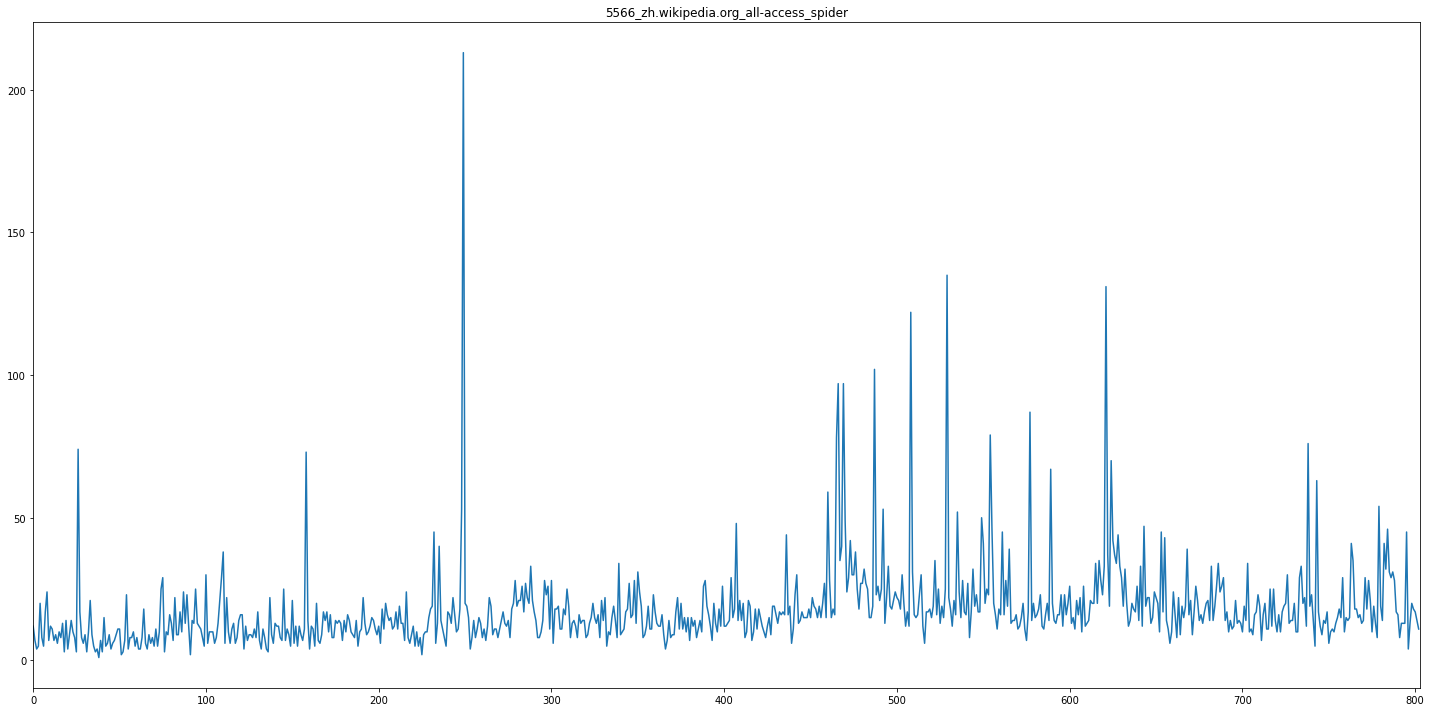

In [247]:
df = df[['5566_zh.wikipedia.org_all-access_spider']]
visualize(df)

In [248]:
test_len = int(len(df) * 0.2)
train, test = df.iloc[:-test_len], df.iloc[-test_len:]

In [249]:
train_len = int(len(train))

In [250]:
model = ARIMA(train, order=(1,1,3), seasonal_order=(1,1,0,8), fit_intercept=False)
model.fit()

ARIMA()

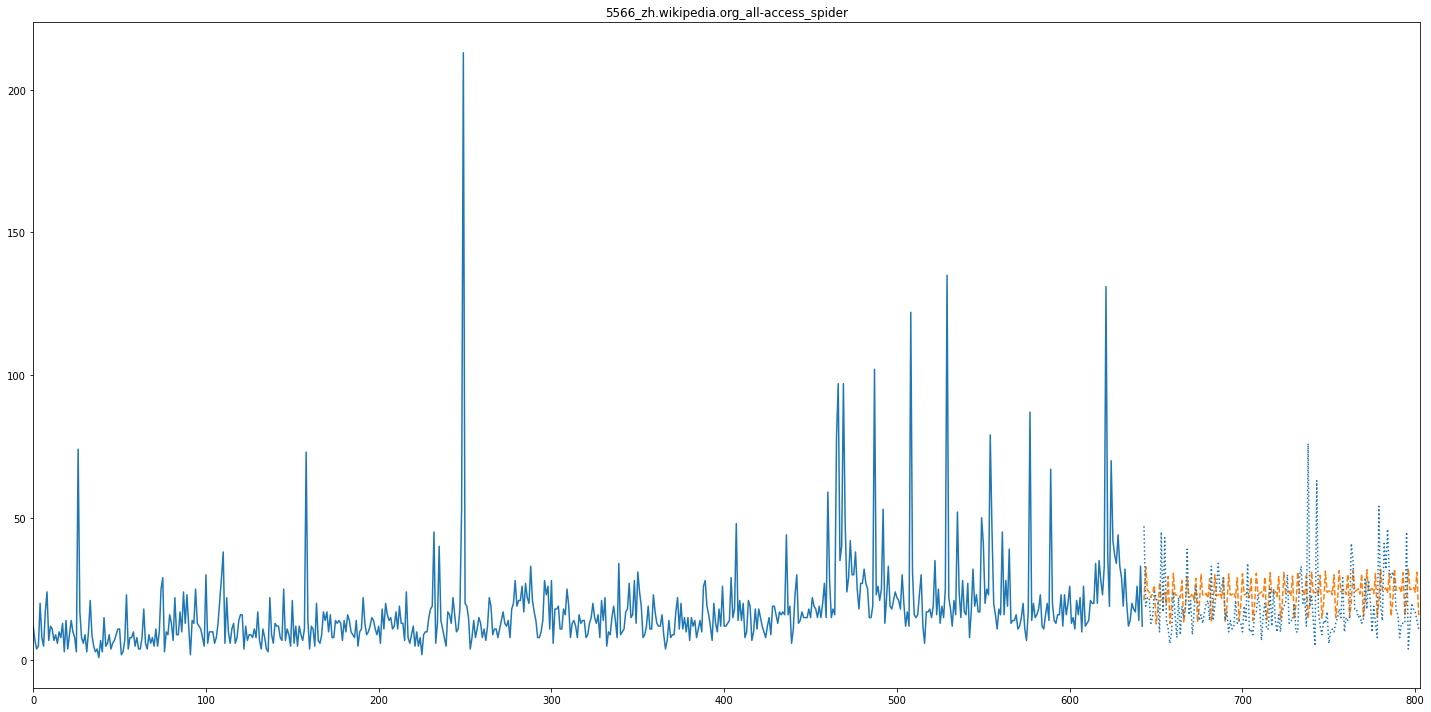

In [251]:
# Forecast
fc = model.forecast(test_len)

# Visualize after the time step 
visualize(train, test ,fc)

To quantify the performance of the baseline methods, I’ll use mean squared error (MSE). 

In [252]:
print(np.power(test.to_numpy() - fc.to_numpy(), 2).mean())

158.89722112980004


Statsmodels ARIMA

In [ ]:
#!pip install sktime==0.6.1

In [157]:
from sktime.forecasting.arima import AutoARIMA

In [187]:
#!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [200]:
df = load_dataset("data")


In [201]:
df = df[['5566_zh.wikipedia.org_all-access_spider']]
test_len = int(len(df) * 0.2)
train, test = df.iloc[:-test_len], df.iloc[-test_len:]

In [ ]:
model = SARIMAX(train, order=(1,1,3), seasonal_order=(1,1,0,8), trend='n')
fitted_model = model.fit()
fc = fitted_model.forecast(test_len)

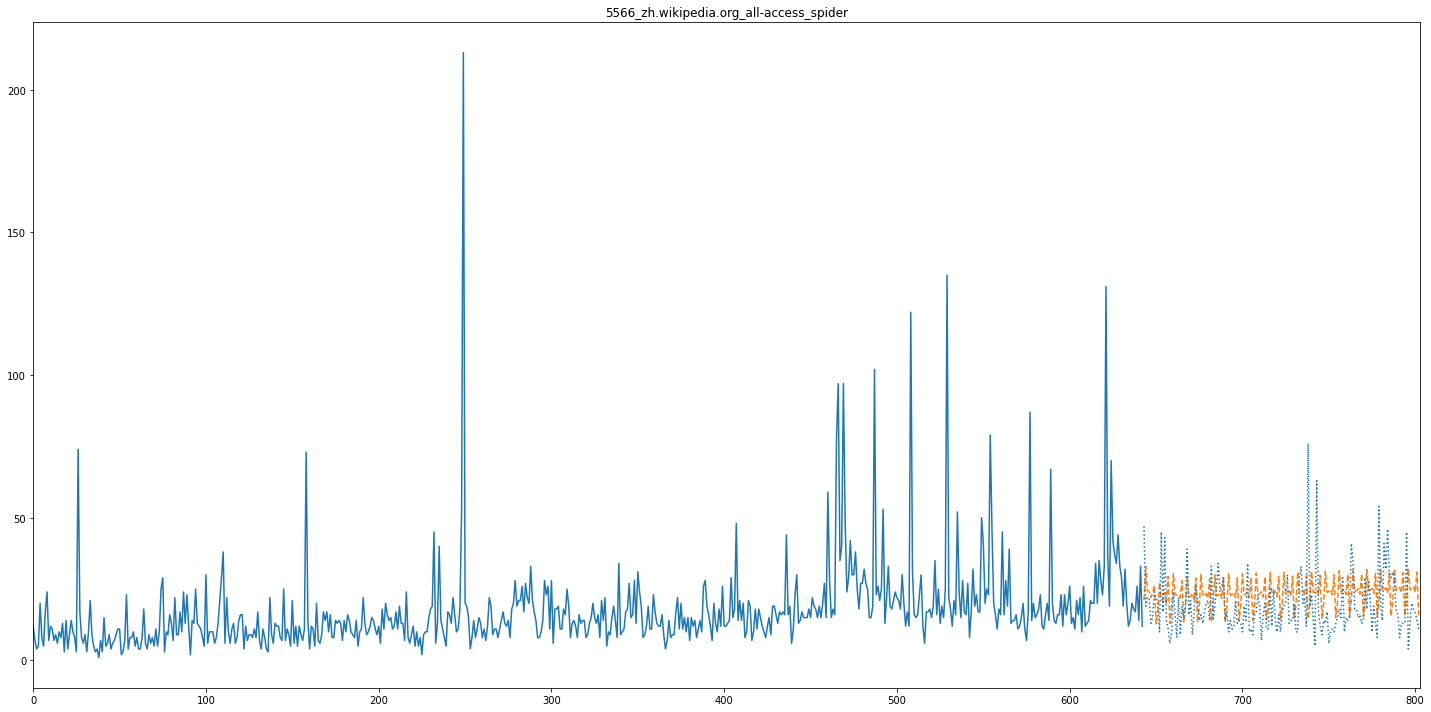

In [203]:
visualize(train, test ,fc)

In [205]:
print(np.power(test.to_numpy() - fc.to_numpy(), 2).mean())

158.89733485317583


Benchmark

In [ ]:
import timeit

In [208]:
def cuml_test(batch):
  df = cudf.from_pandas(load_dataset("data", batch))
  model = ARIMA(df, order=(1,1,3), seasonal_order=(1,1,0,8), fit_intercept=False)
  model = model.fit()
  fc = model.forecast(200)

def sm_test(batch):
  df = load_dataset("data", batch)
  fc_df = pd.DataFrame(columns = df.columns)
  for col in df.columns:
    model = SARIMAX(df[col],order=(1,1,3), seasonal_order=(1,1,0,8), trend='n')
    model = model.fit()
    fc_df[col] = model.forecast(200)

In [ ]:
batch_size = []
cuml_t = []
sm_t = []

for i in range(2,804,50):
  t1 = timeit.timeit(lambda: cuml_test(i) , number =1)
  t2 = timeit.timeit(lambda: sm_test(i), number =1)
  batch_size.append(i-1)
  cuml_t.append(t1)
  sm_t.append(t2)


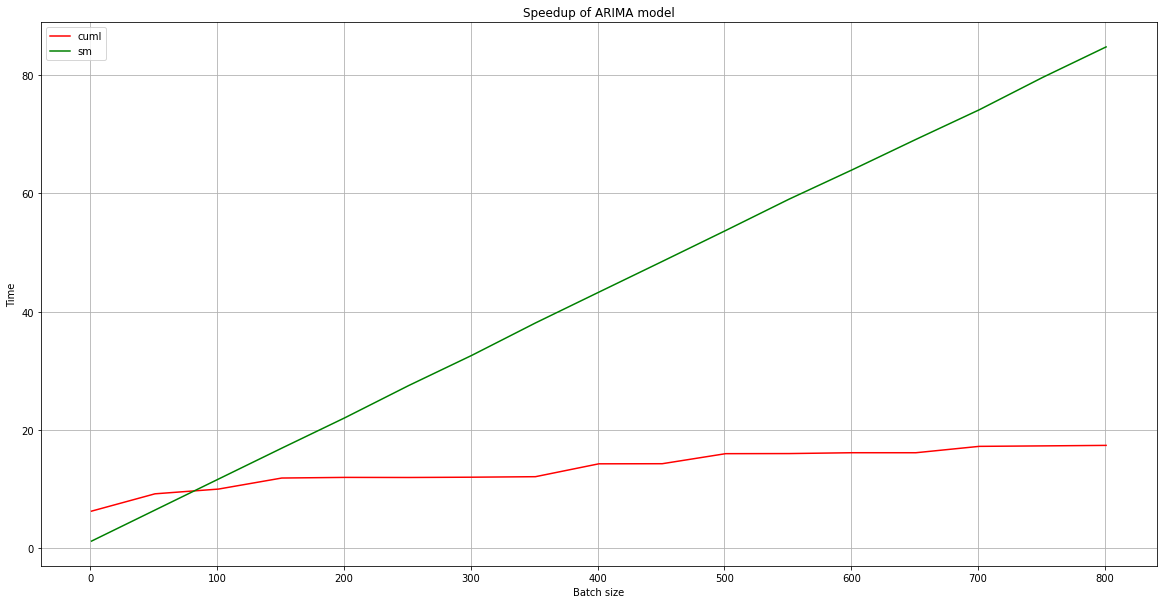

In [ ]:
plt.plot(batch_size,  cuml_t, color='r' ,label='cuml')
plt.plot(batch_size,  sm_t, color='g', label='sm')
plt.title('Speedup of ARIMA model')
plt.xlabel('Batch size')
plt.ylabel('Time')
plt.grid(True)
plt.legend()
plt.show()